# Predicting HDB Resale Prices (2012 - 2021) with Machine Learning

By:

February 2025

## Introduction

The Housing and Development Board (HDB) resale market is a vital component of Singapore's housing landscape, providing flexibility and opportunities for homeowners to sell their flats in the open market. With over 80% of the population residing in HDB flats, understanding the dynamics of the resale market is crucial for both buyers and sellers. Prices in the resale market can vary significantly based on factors such as location, flat type, floor level, and the age of the flat.

Therefore, the purpose of this analysis is to determine the best Machine Learning (ML) model and features that predicts Singapore's HDB resale prices from 2012 to 2021. This analysis involves multiple steps, including installing and importing necessary libraries, feature engineering, feature selection, model pre-processing, and building several Machine Learning models. By following these steps, we aim to build a robust model that can accurately predict HDB resale prices based on historical data. Understanding the factors that influence HDB resale prices can help buyers and sellers make informed decisions in the HDB resale market.

## 1. Install and Import Libraries

In this section, we will install and import the required libraries needed for data manipulation, visualization, and modeling.

In [5]:
# uncomment if need to install libraries

#!pip install pandas numpy matplotlib scikit-learn catboost xgboost

In [6]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from catboost import CatBoostRegressor, Pool

df = pd.read_csv("02_Data.csv")

## 2. Feature Engineering

In this section, we will create new features from the existing dataset that are essential for our analyses. This step also includes creating dummy variables for categorical features and feature scaling.

In [8]:
# converts y/n values to true/false
def convert_yn_to_binary(df):
    for col in df.columns:
        if set(df[col].unique()) <= {"Y","N"}:
            df[col] = df[col].map({"Y": True, "N": False})
    return df

df = convert_yn_to_binary(df)

In [9]:
# check that only categorical features are objects as the following step will convert all objects to dummies
df.dtypes

id                             int64
resale_price                   int64
town                          object
region                        object
flat_type                     object
mid_storey                     int64
floor_area_sqft              float64
max_floor_lvl                  int64
Mall_Nearest_Distance        float64
Hawker_Nearest_Distance      float64
mrt_nearest_distance         float64
bus_stop_nearest_distance    float64
pri_sch_nearest_distance     float64
sec_sch_nearest_dist         float64
cbd_dist                     float64
cpi                          float64
remaining_lease                int64
amenities_within_1km           int64
sora_3mth                    float64
dtype: object

### 2.1. Create Dummies for Categorical Features

Next, we will create dummy variables (one-hot encoding) for categorical features in our dataset. This is essential because ML models require input data to be in numerical form. 

In [12]:
# create dummies for all categorical features
def create_dummies(df):
    object_cols = df.select_dtypes(include=["object"]).columns
    df_dummies = pd.get_dummies(df[object_cols], drop_first=False)
    return df_dummies

df_dummies = create_dummies(df)

In [13]:
# choose dummies to add to original df
chosen_dummies = df_dummies[["flat_type_4 ROOM","region_North-East", "region_East", "region_West"]] # fill in accordingly

df = pd.concat([df,chosen_dummies], axis=1)

### 2.2. Feature Scaling

Next, we will scale all numeric features in the dataset. Feature scaling is crucial for ML models to ensure that all features contribute equally to the model's performance. Additionally, feature scaling aids in faster convergence during optimization processes, improving model training times and performance. Lastly, feature scaling allows for regression coefficients to be compared and interpreted.

In [16]:
# ensure all boolean columns are dtype bool to prevent them from being scaled
def convert_to_boolean(df):
    for col in df.columns:
        if set(df[col].unique()) <= {True, False}:
            df[col] = df[col].astype(bool)
    return df

df = convert_to_boolean(df)

In [17]:
# create an unscaled resale_price column to calculate RMSE at the modelling stage
df["unscaled_resale_price"] = df["resale_price"]

In [18]:
# scale all numeric columns

scaler = StandardScaler()

def scale_numeric_columns(df, exclude_columns = ["id","unscaled_resale_price"]):
    numeric_cols = df.select_dtypes(include = ["int", "float"]).columns
    numeric_cols = numeric_cols.difference(pd.Index(exclude_columns))
    df[numeric_cols] = scaler.fit_transform(df[numeric_cols])
    return df

df = scale_numeric_columns(df)

## 3. Feature Selection

In this section, we select features to include in our model. Feature selection is the process of identifying and selecting the most relevant features in a dataset that contribute significantly to the model's predictive power. It helps in reducing the dimensionality of the data, improving model performance, and making the model more interpretable by focusing on the most impactful features.

We start by including features that have been identified as potentially strong predictors of HDB resale prices based on our Exploratory Data Analyses (EDA). See Tableau workbook.

In [21]:
# Tranc_YearMonth is a datetime and cannot be included in ML
# do not include ID
# always include resale_price and floor_area_sqft

filtered_df = df[["unscaled_resale_price","resale_price","floor_area_sqft","remaining_lease","mid_storey",
                  "cbd_dist","mrt_nearest_distance","max_floor_lvl","Mall_Nearest_Distance","Hawker_Nearest_Distance",
                  "pri_sch_nearest_distance","bus_stop_nearest_distance","sec_sch_nearest_dist","amenities_within_1km",
                  "region_North-East", "region_East", "region_West","flat_type_4 ROOM",
                  "cpi","sora_3mth"
                  ]] # fill in accordingly

In [22]:
# check number of features

filtered_df.shape[1]-2

18

## 4. Model Pre-processing
In this section, we will walk through the essential steps required to prepare our dataset for modeling. The following sections will remove outliers, check for multicollinearity, and create the train-test split for machine learning.

### 4.1. Removal of Outliers
Outliers can skew our model's performance and lead to inaccurate predictions. We will detect and remove outliers from our dataset based on features with z-score (number of standard deviations away from the mean) of less than -3.0 or more than 3.0.

In [25]:
# remove rows with z-scores < -3.0 or > 3.0

def exclude_outliers(filtered_df): 
    filtered_df.loc[:, filtered_df.columns != "unscaled_resale_price"] = \
        filtered_df.loc[:, filtered_df.columns != "unscaled_resale_price"].apply(
            lambda col: col.map(lambda x: x if -3.0 <= x <= 3.0 else None)
        ) 
    return filtered_df.dropna() 

df_cleaned = exclude_outliers(filtered_df)

### 4.2. Check for Multicollinearity
Multicollinearity occurs when features in our dataset are highly correlated. This can negatively impact the model's interpretability and performance. We will use correlation matrices and Pearson's <i>r</i> to identify and address multicollinearity.

If any of the features are highly correlated with other features (<i>r</i> > .7), we will return to [3) Feature Selection](#3.-Feature-Selection) and drop the feature from the list.

In [27]:
# run a correlation matrix amongst the features

corr_matrix = df_cleaned.drop(columns=["unscaled_resale_price","resale_price"]).corr() 

multicollinearity_detected = False 

# check if any values in the correlation matrix exceeds 0.7
# returns pair(s) of values that have a correlation above 0.7
for col in corr_matrix.columns: 
    for row in corr_matrix.index: 
        if row != col and abs(corr_matrix.loc[row, col]) > 0.7: 
            print(f"The correlation between {row} and {col} is {corr_matrix.loc[row, col]}.") 
            multicollinearity_detected = True 

if multicollinearity_detected == False: 
    print("No multicollinearity detected.")

No multicollinearity detected.


### 4.3. Create Train-Test Split
Splitting the dataset into training and testing sets is essential to evaluate our model's performance on unseen data. We will use train-test split to split our dataset into 75% data for training and 25% data for testing.

In [29]:
feature_cols = [col for col in df_cleaned.columns if col not in ["unscaled_resale_price","resale_price"]]
X = df_cleaned[feature_cols]
y = df_cleaned["unscaled_resale_price"]

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=99)  # do not change random state number

## 5. Modelling

In this section, we will dive into building and evaluating the ML models. The use of ML models enables computers to learn from the dataset and make predictions by identifying patterns in the dataset.

We will build and evaluate 4 ML models:

**1) Linear Regression**<br>
**2) XGBoost**<br>
**3) Decision Tree**<br>
**4) CatBoost**

We will use the R-squared and RMSE of the Linear Regression model as baseline metrics to evaluate the performance of our XGBoost, Decision Tree, and CatBoost models. These baselines will help us determine if our models are performing well or if further optimization is needed. By the end of this section, we aim to build models that meet or exceed the baselines of the Linear Regression model, ensuring robust and reliable predictions.

After each model has been built, we will examine the strength of the coefficients (for Linear Regression) or feature importance (for XGBoost, Decision Tree, and CatBoost) to determine which features have the most significant impact on our model's predictions. Based on the results of our models, we will then perform backward selection iteratively to identify the features that give the best performing models.

### 5.1. Build the Linear Regression Model
Linear regression is a simple yet powerful algorithm used to predict a continuous target variable based on one or more input features. It assumes a linear relationship between the inputs and the target. While it is easy to interpret and implement, linear regression may struggle with complex relationships and is prone to overfitting if there are too many features.

- **Speed**: Very Fast
- **Accuracy**: Moderate
- **Overfitting**: Can overfit with many features

In [34]:
%%time
# calculate runtime

# train and fit model
lr = LinearRegression()
lr.fit(X_train, y_train)
    
y_pred_train = lr.predict(X_train)
lr_train_r2 = round(r2_score(y_train, y_pred_train),4)
lr_train_rmse = round(np.sqrt(mean_squared_error(y_train, y_pred_train)),4)
    
print(f"Train R2: {lr_train_r2}")
print(f"Train RMSE: {lr_train_rmse}")

y_pred_test = lr.predict(X_test)
lr_test_r2 = round(r2_score(y_test, y_pred_test),4)
lr_test_rmse = round(np.sqrt(mean_squared_error(y_test, y_pred_test)),4)
    
print(f"Test R2: {lr_test_r2}")
print(f"Train RMSE: {lr_test_rmse}")   

Train R2: 0.8102
Train RMSE: 55717.0162
Test R2: 0.8129
Train RMSE: 55304.2204
CPU times: total: 234 ms
Wall time: 190 ms


In [35]:
# display coefficients and sort in descending order
# features with smaller coefficients should be dropped from 3. Feature Selection

coefficients = lr.coef_
sorted_coefs = sorted(zip(feature_cols, coefficients), key=lambda x: abs(x[1]), reverse=True)
sorted_coefs

[('floor_area_sqft', 98965.88104966338),
 ('cbd_dist', -61804.503240207094),
 ('remaining_lease', 42533.045956629285),
 ('mrt_nearest_distance', -21186.91635975996),
 ('mid_storey', 17569.390547142135),
 ('region_East', 15259.65367740201),
 ('max_floor_lvl', 13743.640005804536),
 ('Hawker_Nearest_Distance', -13647.097215701226),
 ('sora_3mth', -9826.281863590693),
 ('region_North-East', -4800.62022477463),
 ('flat_type_4 ROOM', -3843.783154637987),
 ('pri_sch_nearest_distance', 3546.1027679626914),
 ('sec_sch_nearest_dist', 2659.6768514842647),
 ('Mall_Nearest_Distance', -2510.2684897721215),
 ('bus_stop_nearest_distance', 1304.7663938316057),
 ('region_West', 1045.746100170558),
 ('amenities_within_1km', 360.1419192048678),
 ('cpi', 45.04983624668294)]

### 5.2. Build the XGBoost Model
XGBoost (Extreme Gradient Boosting) is an advanced implementation of gradient boosting that excels in both speed and accuracy. It is particularly well-suited for structured/tabular data. XGBoost offers regularization to prevent overfitting.

- **Speed**: Fast (with optimizations)
- **Accuracy**: High
- **Overfitting**: Reduced with built-in regularization

In [37]:
%%time
# calculate runtime

# train and fit model
model = xgb.XGBRegressor(objective='reg:squarederror', max_depth = 7, learning_rate = 0.1, n_estimators = 500)

model.fit(X_train, y_train)

y_pred_train = model.predict(X_train)
train_r2 = round(r2_score(y_train, y_pred_train), 4)
train_rmse = round(np.sqrt(mean_squared_error(y_train, y_pred_train)), 4)
    
if train_r2 >= lr_train_r2:
    print(f"Train R2: {train_r2} - Exceeds Baseline")
else:
    print(f"Train R2: {train_r2} - Does Not Exceed Baseline")
if train_rmse <= lr_train_rmse:
    print(f"Train RMSE: {train_rmse} - Exceeds Baseline")
else:
    print(f"Train RMSE: {train_rmse} - Does Not Exceed Baseline")

y_pred_test = model.predict(X_test)
test_r2 = round(r2_score(y_test, y_pred_test),4)
test_rmse = round(np.sqrt(mean_squared_error(y_test, y_pred_test)),4)
    
if test_r2 >= lr_test_r2:
    print(f"Test R2: {test_r2} - Exceeds Baseline")
else:
    print(f"Test R2: {test_r2} - Does Not Exceed Baseline")
if test_rmse <= lr_test_rmse:
    print(f"Train RMSE: {test_rmse} - Exceeds Baseline")
else:
    print(f"Train RMSE: {test_rmse} - Does Not Exceed Baseline")

Train R2: 0.9809 - Exceeds Baseline
Train RMSE: 17692.6058 - Exceeds Baseline
Test R2: 0.9681 - Exceeds Baseline
Train RMSE: 22854.335 - Exceeds Baseline
CPU times: total: 11.4 s
Wall time: 3.41 s


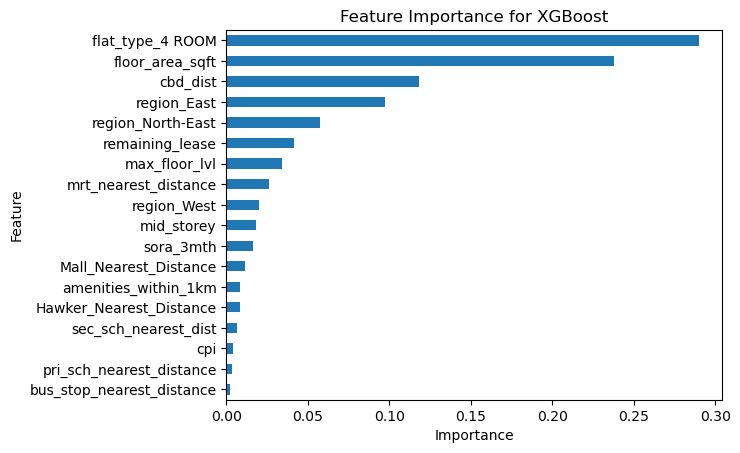

In [38]:
# display feature importance and sort in descending order
# features with smaller importance should be dropped from 3. Feature Selection
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances = feat_importances.sort_values(ascending=True)
feat_importances.plot(kind='barh')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance for XGBoost')
plt.show()

### 5.3. Build the Decision Tree Model
A decision tree splits the data into subsets based on the most significant features. Decision trees are easy to interpret and visualize but can easily overfit the training data if not pruned properly.

- **Speed**: Fast
- **Accuracy**: Moderate
- **Overfitting**: High, if not pruned

In [40]:
%%time
# calculate runtime

# train and fit model
model = DecisionTreeRegressor(random_state = 99) # do not change random state number

model.fit(X_train, y_train)

y_pred_train = model.predict(X_train)
train_r2 = round(r2_score(y_train, y_pred_train), 4)
train_rmse = round(np.sqrt(mean_squared_error(y_train, y_pred_train)), 4)
    
if train_r2 >= lr_train_r2:
    print(f"Train R2: {train_r2} - Exceeds Baseline")
else:
    print(f"Train R2: {train_r2} - Does Not Exceed Baseline")
if train_rmse <= lr_train_rmse:
    print(f"Train RMSE: {train_rmse} - Exceeds Baseline")
else:
    print(f"Train RMSE: {train_rmse} - Does Not Exceed Baseline")

y_pred_test = model.predict(X_test)
test_r2 = round(r2_score(y_test, y_pred_test),4)
test_rmse = round(np.sqrt(mean_squared_error(y_test, y_pred_test)),4)
    
if test_r2 >= lr_test_r2:
    print(f"Test R2: {test_r2} - Exceeds Baseline")
else:
    print(f"Test R2: {test_r2} - Does Not Exceed Baseline")
if test_rmse <= lr_test_rmse:
    print(f"Train RMSE: {test_rmse} - Exceeds Baseline")
else:
    print(f"Train RMSE: {test_rmse} - Does Not Exceed Baseline")

Train R2: 0.9999 - Exceeds Baseline
Train RMSE: 1527.6947 - Exceeds Baseline
Test R2: 0.9271 - Exceeds Baseline
Train RMSE: 34533.3721 - Exceeds Baseline
CPU times: total: 1.77 s
Wall time: 1.84 s


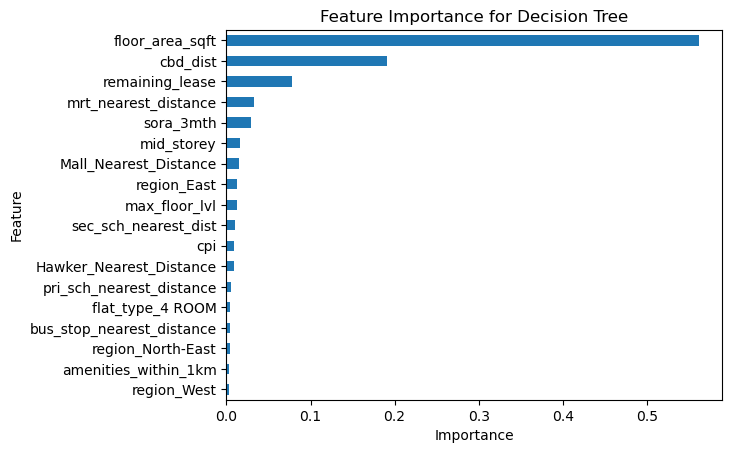

In [41]:
# display feature importance and sort in descending order
# features with smaller importance should be dropped from 3. Feature Selection
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances = feat_importances.sort_values(ascending=True)
feat_importances.plot(kind='barh')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance for Decision Tree')
plt.show()

### 5.4. Build the CatBoost Model
CatBoost is a gradient boosting algorithm that offers high accuracy and is less prone to overfitting compared to other boosting methods. CatBoost provides robust performance across various types of data.

- **Speed**: Moderate (with categorical features)
- **Accuracy**: High
- **Overfitting**: Reduced with built-in techniques

In [43]:
%%time
# calculate runtime

# train and fit model
model = CatBoostRegressor(iterations=1000, learning_rate=0.1, depth=6, verbose=0)

model.fit(X_train, y_train)

y_pred_train = model.predict(X_train)
train_r2 = round(r2_score(y_train, y_pred_train), 4)
train_rmse = round(np.sqrt(mean_squared_error(y_train, y_pred_train)), 4)
    
if train_r2 >= lr_train_r2:
    print(f"Train R2: {train_r2} - Exceeds Baseline")
else:
    print(f"Train R2: {train_r2} - Does Not Exceed Baseline")
if train_rmse <= lr_train_rmse:
    print(f"Train RMSE: {train_rmse} - Exceeds Baseline")
else:
    print(f"Train RMSE: {train_rmse} - Does Not Exceed Baseline")

y_pred_test = model.predict(X_test)
test_r2 = round(r2_score(y_test, y_pred_test),4)
test_rmse = round(np.sqrt(mean_squared_error(y_test, y_pred_test)),4)
    
if test_r2 >= lr_test_r2:
    print(f"Test R2: {test_r2} - Exceeds Baseline")
else:
    print(f"Test R2: {test_r2} - Does Not Exceed Baseline")
if test_rmse <= lr_test_rmse:
    print(f"Train RMSE: {test_rmse} - Exceeds Baseline")
else:
    print(f"Train RMSE: {test_rmse} - Does Not Exceed Baseline")

Train R2: 0.9698 - Exceeds Baseline
Train RMSE: 22208.368 - Exceeds Baseline
Test R2: 0.9651 - Exceeds Baseline
Train RMSE: 23881.1383 - Exceeds Baseline
CPU times: total: 45.4 s
Wall time: 12.5 s


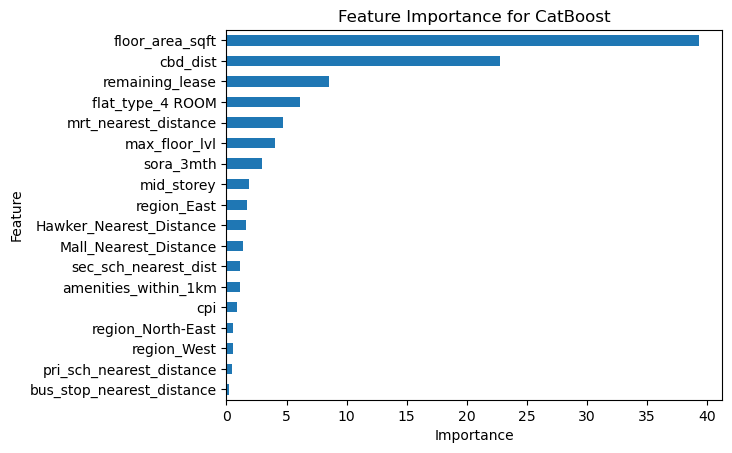

In [44]:
# display feature importance and sort in descending order
# features with smaller importance should be dropped from 3. Feature Selection
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances = feat_importances.sort_values(ascending=True)
feat_importances.plot(kind='barh')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance for CatBoost')
plt.show()

## 6. Conclusion and Recommendations

In this notebook, we explored various ML models to predict HDB resale prices in Singapore. By evaluating the trade-offs between train and test R-squared, model discrepancies, RMSE, and runtime, we have identified **XGBoost** as the best model.

The following table summarizes the performance of the models we evaluated:
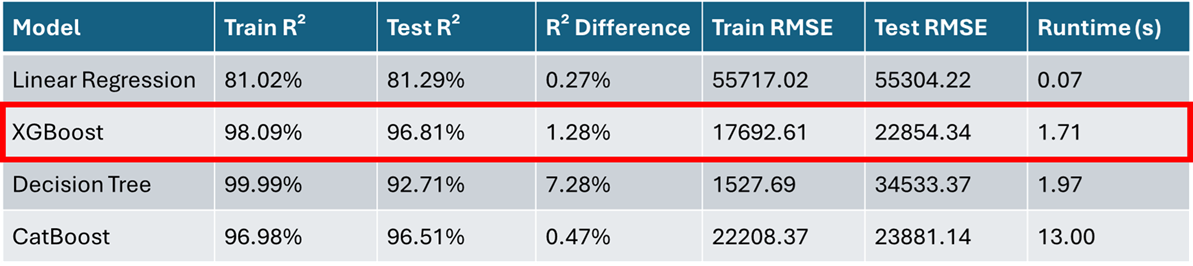

XGBoost demonstrated superior performance with a high train and test R-squared and low RMSE, while maintaining a reasonable runtime. Importantly, this model exhibits no significant overfitting and surpasses our baseline metrics of 90% accuracy and RMSE of less than 50,000.

Across the models, the strongest predictors of HDB resale prices were identified as:
- **Floor Area**
- **Distance to CBD**
- **Remaining Lease**
- **Floor Level**
- **Distance to Amenities**
- **Flat Types**
- **Consumer Price Index and Bank Interest Rates (SORA)**

These predictors provide valuable insights into the factors that most significantly influence resale prices, helping us understand the dynamics of the HDB resale market.

The machine learning model we developed in this notebook can be highly beneficial for various stakeholders in the HDB resale market. *Buyers* can use the model to gain a clearer understanding of fair market prices based on specific attributes of flats, and make informed decisions on potential investments by assessing the impact of key factors on resale prices. *Sellers* can learn how to set competitive and realistic prices for their flats, increasing the chances of a successful sale. *Real estate agents* can provide data-driven recommendations to clients on buying or selling flats, while leveraging predictive insights to analyze market conditions and identify lucrative opportunities.

By harnessing the power of machine learning, our model offers a comprehensive and data-driven approach to navigating the HDB resale market. 

We hope everyone will find our analyses useful.

Key references include:
* [Scikit-learn](https://scikit-learn.org/)
* [XGBoost Documentation](https://xgboost.readthedocs.io/)
* [CatBoost Documentation](https://catboost.ai/)
* [Stack Overflow](https://stackoverflow.com/)